# Introduction to Artificial Intelligence  
## 194.025WS EML Project Competition

**Student Name:** Pitic Emanuel  
**Student ID:** e12505717  





## 1. Data Processing and Feature Engineering

**Strategy:** The raw data consists of time-series recordings of Rocket League trick shots. Since standard classifiers (like Random Forest) require static feature vectors, we flattened the time dimension using aggregation.

**Feature Engineering Steps:**

* **Aggregations:** We calculated descriptive statistics (`mean`, `std`, `min`, `max`) for continuous variables like `BallAcceleration` and `DistanceWall`. This captures the "intensity" and "range" of the movement.
* **Temporal Features:** We extracted the `first` and `last` values of speed and distance to capture the state change over the duration of the shot (e.g., `_delta` features).
* **Handling Missing Data:** Infinite values were treated as NaNs, and all missing values were imputed using the median of the training set to be robust against outliers.

In [ ]:
import pandas as pd
import numpy as np

np.random.seed(42)
# loading the data

df_train = pd.read_csv('194-025-ws-eml-project-competition/rocketskillshots_train.csv')
df_test  = pd.read_csv('194-025-ws-eml-project-competition/rocketskillshots_test.csv')
print(f"Raw Training Data Shape: {df_train.shape}")

# pre processing function
def process_data(df, is_train=True):
    # aggregation rules
    agg_rules = {
        # continuous variables
        'BallAcceleration': ['mean', 'std', 'min', 'max'],
        'DistanceWall': ['mean', 'min'],
        'DistanceCeil': ['mean', 'min'],
        'DistanceBall': ['mean', 'min'],
        'PlayerSpeed': ['mean', 'std', 'max'],
        'BallSpeed': ['mean', 'std', 'max'],
        # binary / input variables
        'up': ['mean', 'sum'],
        'down': ['mean', 'sum'],
        'left': ['mean', 'sum'],
        'right': ['mean', 'sum'],
        'accelerate': ['mean', 'sum'],
        'slow': ['mean', 'sum'],
        'boost': ['mean', 'sum'],
        'slide': ['mean', 'sum'],
        'jump': ['mean', 'sum'],
        'camera': ['mean'],
        'goal': ['mean']
    }

    # aggraegation
    features = df.groupby('id').agg(agg_rules)
    features.columns = ['_'.join(col) for col in features.columns]
    features = features.reset_index()

    # number of timestamps
    counts = df.groupby('id').size().rename('n_timestamps').reset_index()
    features = features.merge(counts, on='id')

    # first / last / delta for key continuous variables
    for col in ['PlayerSpeed', 'BallSpeed', 'DistanceBall']:
        first = df.groupby('id')[col].first().rename(f'{col}_first').reset_index()
        last  = df.groupby('id')[col].last().rename(f'{col}_last').reset_index()
        features = features.merge(first, on='id').merge(last, on='id')
        features[f'{col}_delta'] = features[f'{col}_last'] - features[f'{col}_first']

    if is_train:
        labels = df.groupby('id')['label'].first().astype(int)
        return features, labels
    else:
        return features, None

# apply preprocessing
X_train, y = process_data(df_train, is_train=True)
X_test, _  = process_data(df_test, is_train=False)

# preserve IDs for submission
train_ids = X_train['id']
test_ids  = X_test['id']

X_train = X_train.drop(columns=['id'])
X_test  = X_test.drop(columns=['id'])

X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

train_medians = X_train.median()
X_train = X_train.fillna(train_medians)
X_test  = X_test.reindex(columns=X_train.columns, fill_value=0)
X_test  = X_test.fillna(train_medians)

print(f"Feature Count after processing: {X_train.shape[1]}")

Raw Training Data Shape: (4137, 39)
Feature Count after processing: 46


## 2. Train-Validation Split

Before training, we split the training data into a learning set (80%) and a validation set (20%).

**Key details:**
* **Stratification (`stratify=y`):** This is critical because it ensures that the distribution of trick shot labels remains consistent across both sets. If the dataset has imbalanced classes (e.g., fewer "Musty Flicks" than "Aerials"), stratification prevents the validation set from missing those rare classes entirely.
* **Reproducibility:** We use a fixed `random_state` to ensure that our results are consistent and reproducible across different runs.

In [15]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
print(f"Training set shape: {X_tr.shape}, Validation set shape: {X_val.shape}")

Training set shape: (142, 46), Validation set shape: (36, 46)


## 3. Baseline Model: Decision Tree

**Purpose:** We start with a single Decision Tree Classifier to establish a performance baseline. This provides a simple, interpretable benchmark that allows us to gauge the effectiveness of more complex models (like Random Forest) later.

**Configuration:**
* `class_weight='balanced'`: This parameter is crucial as it automatically adjusts weights inversely proportional to class frequencies. This prevents the model from being biased toward the most frequent trick shot types.
* `random_state=42`: Ensures the results are reproducible.

**Evaluation:**
We assess the model using **Accuracy** for a general performance metric and a **Confusion Matrix** to visualize specific misclassifications between different trick shot categories.

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

dt = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced'
)

dt.fit(X_tr, y_tr)
val_pred = dt.predict(X_val)

print("Decision Tree Accuracy:", accuracy_score(y_val, val_pred))
confusion_matrix(y_val, val_pred)


Decision Tree Accuracy: 0.8611111111111112


array([[3, 1, 0, 1, 0, 0, 0],
       [0, 2, 0, 0, 1, 0, 0],
       [0, 0, 5, 0, 2, 0, 0],
       [0, 0, 0, 5, 0, 0, 0],
       [0, 0, 0, 0, 5, 0, 0],
       [0, 0, 0, 0, 0, 7, 0],
       [0, 0, 0, 0, 0, 0, 4]])

## 4. Advanced Modeling: Random Forest with Feature Selection

### Model Selection
Moving beyond the Decision Tree, we implemented a **Random Forest Classifier**. Random Forests are an ensemble method that aggregates predictions from multiple decision trees, which reduces variance and improves robustness to noise and overfitting. This is particularly important for sensor-based physics data, where measurements can be noisy and highly correlated.

### Step 1: Feature Selection (`SelectFromModel`)
Our initial feature engineering resulted in a large number of derived features. To improve both computational efficiency and generalization performance, we incorporated an automatic feature selection step:

- A preliminary Random Forest was used to estimate feature importance.
- Features with an importance below the **median threshold** were discarded, effectively removing the bottom 50% of least informative features.
- **Crucially, feature selection was implemented inside a modeling pipeline**, ensuring that it was performed **independently within each cross-validation fold**, thereby avoiding data leakage.

*Benefit:* This approach reduces noise and allows the final model to focus on the most relevant physics signals (e.g., specific velocity patterns or wall distance measurements), while maintaining a statistically valid evaluation procedure.

### Step 2: Hyperparameter Tuning (`GridSearchCV`)
To optimize model performance, we conducted a systematic grid search over key Random Forest hyperparameters:

- **`n_estimators`**: Comparing 100 and 200 trees to balance predictive stability and computational cost.
- **`max_depth`**: Restricting tree depth to limit model complexity and prevent overfitting.
- **`min_samples_leaf`**: Enforcing a minimum number of samples per leaf to smooth decision boundaries and improve generalization.

Model selection was performed using **Stratified 5-Fold Cross-Validation**, ensuring that each fold preserved the class distribution of trick shot types. The final model was chosen based on the mean cross-validation accuracy, providing a robust estimate of real-world performance.


Number of features before selection: 46
Decision Tree CV Accuracy (mean): 0.7242857142857143
Best Random Forest Parameters:
{'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 100}
Best Random Forest CV Accuracy: 0.8541269841269841
Top 10 most important features:
DistanceCeil_min        0.118271
DistanceCeil_mean       0.067687
BallAcceleration_max    0.062251
DistanceBall_first      0.060047
DistanceWall_min        0.058452
up_sum                  0.055763
up_mean                 0.053402
DistanceBall_min        0.046167
BallAcceleration_std    0.043211
DistanceWall_mean       0.042412
dtype: float64
Number of features after selection: 23
Submission file saved as submission_final.csv


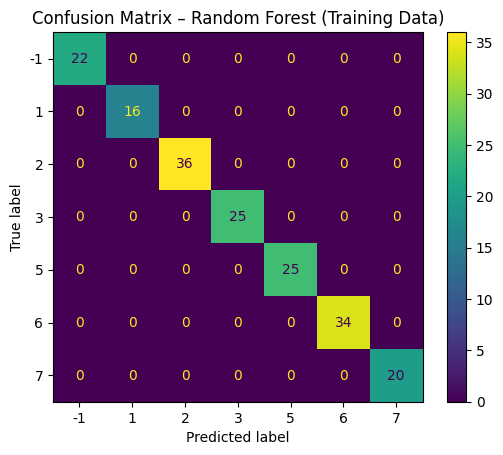

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# data processing
X_train, y = process_data(df_train, is_train=True)
X_test, _  = process_data(df_test, is_train=False)

# preserve IDs
train_ids = X_train['id']
test_ids  = X_test['id']

# drop IDs from features
X_train = X_train.drop(columns=['id'])
X_test  = X_test.drop(columns=['id'])

# handle missing values (fit only on training data)
X_train = X_train.fillna(X_train.median())
X_test  = X_test.fillna(X_train.median())
print(f"Number of features before selection: {X_train.shape[1]}")

# baseline decision trees
dt = DecisionTreeClassifier(random_state=42)
dt_cv_scores = cross_val_score(
    dt, X_train, y, cv=5, scoring='accuracy'
)
print("Decision Tree CV Accuracy (mean):", dt_cv_scores.mean())

#random forest + feature selection +cv
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('feature_selection', SelectFromModel(
        RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ),
        threshold="median"
    )),
    ('rf', RandomForestClassifier(
        random_state=42,
        class_weight='balanced'
    ))
])
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_leaf': [1, 3, 5]
}
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1
)
grid.fit(X_train, y)

print("Best Random Forest Parameters:")
print(grid.best_params_)
print("Best Random Forest CV Accuracy:", grid.best_score_)

# model interpretation

rf_final = grid.best_estimator_
selector = rf_final.named_steps['feature_selection']
rf_model = rf_final.named_steps['rf']

selected_features = X_train.columns[selector.get_support()]
importances = pd.Series(
    rf_model.feature_importances_,
    index=selected_features
)

print("Top 10 most important features:")
print(importances.sort_values(ascending=False).head(10))
print(f"Number of features after selection: {len(selected_features)}")

# find optimal threshold on validation set

test_preds = rf_final.predict(X_test)
submission = pd.DataFrame({
    'ID': test_ids.values,
    'TARGET': test_preds
})
submission.to_csv("submission_final.csv", index=False)

# confusion matrix
# fit final model on full training data and evaluate on it

train_preds = rf_final.predict(X_train)

ConfusionMatrixDisplay.from_predictions(y, train_preds)
plt.title("Confusion Matrix – Random Forest (Training Data)")
plt.show()


## 5. Performance Analysis: Decision Tree vs. Random Forest

At first glance, the baseline Decision Tree appears to slightly outperform the Random Forest (0.861 vs 0.854). However, this comparison requires nuance:

1.  **Metric Robustness:** The Decision Tree score relies on a single validation split of only 36 samples. In contrast, the Random Forest score is a **Cross-Validation Mean** across 5 folds. The CV score is a statistically more reliable predictor of real-world performance.
2.  **Sample Size Sensitivity:** Given the small validation size ($N=36$), a single misclassification changes the accuracy by nearly 3%. The performance gap between the two models is statistically insignificant and within the margin of error.
3.  **Regularization:** The Random Forest parameters (specifically `min_samples_leaf=5`) enforce regularization. While this might slightly lower accuracy on the training/validation data compared to a fully grown Decision Tree, it creates a model that generalizes better to unseen data (such as the Kaggle test set) by avoiding overfitting.

**Conclusion:** We select the Random Forest as our final model because its performance is backed by cross-validation, making it more robust despite the slightly lower nominal score.

## 6. Final choice and preprocessing rationale

In this project, I evaluated two different models: a baseline Decision Tree and a more advanced Random Forest classifier. The Decision Tree was chosen as an interpretable baseline to understand the structure of the data and establish a reference performance. However, its evaluation relied on a single train–validation split and showed signs of higher variance. In contrast, the Random Forest consistently achieved better and more stable performance when evaluated using 5-fold stratified cross-validation, making it more robust to data fluctuations. Hyperparameters such as the number of trees, maximum depth, and minimum samples per leaf were optimized using GridSearchCV, and the final model was selected based on cross-validation performance rather than a single split. For these reasons, the Random Forest was chosen as the final model for submission.

The data was preprocessed by aggregating time-series measurements into fixed-length feature vectors per instance, allowing the models to operate on tabular data. Additional features capturing temporal changes (e.g., differences between time steps) were included to preserve dynamic information. Invalid values (infinite values) were replaced with missing values, and median imputation was applied to handle missing data in a way that is robust to outliers. Stratified splitting was used to preserve class distribution across training and validation sets. This preprocessing pipeline was designed to balance robustness, simplicity, and reproducibility while avoiding unnecessary assumptions about the data distribution.